In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline


Here we start with simple cross-validation, no balancing (later will add balancing)

In [43]:
datadir = "../data"
savedir = "../saves/catboost_multiple_features"
if not os.path.exists(savedir):
    os.makedirs(savedir)
print(os.listdir(datadir))
df_train_single=pd.read_csv(os.path.join(datadir, "single_muts_train.csv"))
df_train_multiple = pd.read_csv(os.path.join(datadir, "multiple_muts_train.csv"))
df_train = pd.concat([df_train_single, df_train_multiple], ignore_index=True)

df_test = pd.read_csv(os.path.join(datadir, "multiple_muts_test.csv"))

df_train['topology'] = df_train.name.apply(lambda x: x.split("_")[0])
df_test['topology'] = df_test.name.apply(lambda x: x.split("_")[0])

df_train['name'] = df_train.name.apply(lambda x: x.split(".")[0])
df_test['name'] = df_test.name.apply(lambda x: x.split(".")[0])


df_train = df_train.loc[~df_train.stabilityscore.isnull()]
df_test = df_test.loc[~df_test.stabilityscore.isnull()]

['.DS_Store', 'features', 'multiple_muts_test.csv', 'multiple_muts_train.csv', 'pdb', 'pdb_names.csv', 'pdb_names_with_cmaps.csv', 'single_muts_test.csv', 'single_muts_train.csv', 'wt_sequences.csv']


In [44]:
#df_train.secondary_structure.apply(lambda x: )

# 1. Start with sequence-based prediction

In [45]:
sorted(set([x for xs in df_test.sequence for x in xs]))
#df_train[['sequence', "stabilityscore"]].values


['A',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [46]:
aa = """Alanine	Ala	A
Arginine	Arg	R
Asparagine	Asn	N
Aspartic Acid	Asp	D
Cysteine	Cys	C
Glutamic Acid	Glu	E
Glutamine	Gln	Q
Glycine	Gly	G
Histidine	His	H
Isoleucine	Ile	I
Leucine	Leu	L
Lysine	Lys	K
Methionine	Met	M
Phenylalanine	Phe	F
Proline	Pro	P
Serine	Ser	S
Threonine	Thr	T
Tryptophan	Trp	W
Tyrosine	Tyr	Y
Valine	Val	V"""

aadict = dict()
for line in aa.split("\n"):
    data = line.split()
    if len(data)< 3:
        continue
    name = " ".join(data[0:-2])
    l3, l1 = data[-2:]
    aadict[l1] = (name, l3)
aa = sorted(aadict)
aa2idx = {x: i for i, x in enumerate(aa)}

ss2idx = {"E":0, "T": 1, "H": 2}

In [89]:
from collections import OrderedDict

def calc_buriedArea(seq):
    'Values taken from https://web.expasy.org/protscale/pscale/Averageburied.html'
    dictionary = {
        "A": 86.600,
        "C": 132.300,
        "D": 97.800,
        "E": 113.900,
        "F": 194.100,
        "G": 62.900,
        "H": 155.800,
        "I": 158.000,
        "K": 115.500,
        "L": 164.100,
        "M": 172.900,
        "N": 103.300,
        "P": 92.900,
        "Q": 119.200,
        "R": 162.200,
        "S": 85.600,
        "T": 106.500,
        "V":141.000,
        "W":224.600,
        "Y":177.700
    }
    return np.sum([dictionary[i] for i in seq])


def calc_polarity(seq):
    '''
    {'A': 0, 'C': 1, 'D': 2, 'E': 3, 
    'F': 4, 'G': 5, 'H': 6, 'I': 7, 
    'K': 8, 'L': 9, 'M': 10, 'N': 11, 
    'P': 12, 'Q': 13, 'R': 14, 'S': 15, 
    'T': 16, 'V': 17, 'W': 18, 'Y': 19}
    '''
    dictionary={
        "A": 8.100,
        "C": 5.500,
        "D": 97.800,
        "E": 113.900,
        "F": 194.100,
        "G": 62.900,
        "H": 155.800,
        "I": 158.000,
        "K": 115.500,
        "L": 164.100,
        "M": 172.900,
        "N": 103.300,
        "P": 92.900,
        "Q": 119.200,
        "R": 162.200,
        "S": 85.600,
        "T": 106.500,
        "V": 141.000,
        "W": 224.600,
        "Y": 177.700
    }
    return np.sum([dictionary[i] for i in seq])


def read_params(file):
    triple_to_single={
        'Ala':'A',
        'Arg':'R',
        'Asn':'N',
        'Asp':'D',
        'Cys':'C',
        'Gln':'Q',
        'Glu':'E',
        'Gly':'G',
        'His':'H',
        'Ile':'I',
        'Leu':'L',
        'Lys':'K',
        'Met':'M',
        'Phe':'F',
        'Pro':'P',
        'Ser':'S',
        'Thr':'T',
        'Trp':'W',
        'Tyr':'Y',
        'Val':'V'
    
    }
    
    single_to_encoder={'A': 0, 'C': 1, 'D': 2, 
                       'E': 3, 'F': 4, 'G': 5, 
                       'H': 6, 'I': 7, 'K': 8, 
                       'L': 9, 'M': 10, 'N': 11, 
                       'P': 12, 'Q': 13, 'R': 14, 
                       'S': 15, 'T': 16, 'V': 17, 
                       'W': 18, 'Y': 19}
    
    dictionary = {}
    with open(file,'r') as input_file:
        for i in input_file.readlines():
            #print(i)
            if i.startswith(' '):
                continue
            elif i.startswith('\n'):
                pass
            else:
                aavalue = i.split(':')
                #print(aavalue)
                single=triple_to_single[aavalue[0]]
                # encoder=single_to_encoder[single]
                dictionary.update({single: aavalue[1].strip()})
    return dictionary


def calc_feature(feature):
    dictionary = read_params('../data/features/'+str(feature)+'.txt')
    # print(dictionary)
    def compute_features(seq):
        feature = 0.0
        for i in seq:
            feature += float(dictionary[i])
        return feature
    return compute_features

calc_feature('polarity')(df_train.sequence[0])
feature_list = os.listdir('../data/features')
feature_functions = OrderedDict()
for i in feature_list:
    feature_name = i.split('.')[0]
    feature_functions[feature_name] = calc_feature(feature_name)
#list(feature_functions.items())

In [90]:
train_features = np.stack([
    df_train.sequence.apply(func).values
    for name, func in list(feature_functions.items())+[
        ("calc_buriedArea", calc_buriedArea),
        ("calc_polarity", calc_polarity)
    ]
], 1)

test_features = np.stack([
    df_test.sequence.apply(func).values
    for name, func in list(feature_functions.items())+[
        ("calc_buriedArea", calc_buriedArea),
        ("calc_polarity", calc_polarity)
    ]
], 1)
    

In [91]:
#test_features.shape, x_full_train.shape
list(feature_functions)

['aa_composition',
 'alpha-helix-Deleage',
 'alpha-helix-Levitt',
 'antiparallel_betasheet',
 'average_flexibility',
 'beta-sheet',
 'beta-turn-Levitt',
 'beta-turn',
 'betaturn_chou',
 'bulkiness',
 'buried_residues',
 'coil-Deleage',
 'hydrophobicity-abraham',
 'hydrophobicity-kyte',
 'number_of_codons',
 'polarity-Zimmermann',
 'polarity',
 'ratio_hetero_end-side',
 'recognition_factors',
 'refractivity',
 'relative_mutability',
 'transmembrane_tendency']

In [92]:
x_full_train = pd.concat([
    pd.DataFrame(
        np.stack(df_train.sequence.apply(lambda xs: np.asarray([aa2idx[x] for x in xs])).values),
        columns=[f"aa{x}" for x in np.arange(43)]
    ),
    pd.DataFrame(
        np.stack(df_train.secondary_structure.apply(lambda xs: np.asarray([ss2idx[x] for x in xs])).values),
        columns=[f"ss{x}" for x in np.arange(43)]
    ),
    pd.DataFrame(train_features)
], 1)
y_full_train = df_train.stabilityscore.values

# x_full_test = np.stack(df_test.sequence.apply(lambda xs: np.asarray([aa2idx[x] for x in xs])).values)
x_full_test = pd.concat([
    pd.DataFrame(
        np.stack(df_test.sequence.apply(lambda xs: np.asarray([aa2idx[x] for x in xs])).values),
        columns=[f"aa{x}" for x in np.arange(43)]
    ),
    pd.DataFrame(
        np.stack(df_test.secondary_structure.apply(lambda xs: np.asarray([ss2idx[x] for x in xs])).values),
        columns=[f"ss{x}" for x in np.arange(43)]
    ),
    pd.DataFrame(test_features)
], 1)
y_full_test = df_test.stabilityscore.values

In [93]:
#x_full_train = np.stack(df_train.sequence.apply(lambda xs: np.asarray([aa2idx[x] for x in xs])).values)
topologies = sorted(df_train.topology.drop_duplicates().values)
top2idx = {x: i for i, x in enumerate(topologies)}
names = sorted(list(df_train.name.drop_duplicates().values)+list(df_test.name.drop_duplicates().values))
name2idx = {x: i for i, x in enumerate(names)}
# df_test[~df_test.name.isin(names)]

topologies_train = df_train.topology.apply(lambda x: top2idx[x]).values
names_train = df_train.name.apply(lambda x: name2idx[x]).values

topologies_test = df_test.topology.apply(lambda x: top2idx[x]).values
names_test = df_test.name.apply(lambda x: name2idx[x]).values

In [94]:
NFOLDS = 5
RANDOM_SEED = 42

SAVE_PREFIX = os.path.join(savedir, "catboost_multi_kf_")
from sklearn.model_selection import KFold
from catboost import Pool, CatBoostRegressor
cat_features=[f"aa{x}" for x in np.arange(43)]+[f"ss{x}" for x in np.arange(43)]#x_full_train.shape[1])
NITERATIONS=1000


In [95]:
# # in normal production setting cv is used just to search for model parameters,
# # after that the model is trained on the whole train dataset.
# # Let's compare our best model R^2 on test with the best ensemble.
# # it won't be better than ensemble in the terms of performance, but it will run on new data faster.
# model_all_data = CatBoostRegressor(
#     iterations=NITERATIONS, depth=7, learning_rate=1, loss_function='RMSE',
#     metric_period=NITERATIONS//10
# )
# model_all_data.fit(
#     x_full_train, y_full_train, eval_set=(x_full_train, y_full_train),
#     #cat_features=cat_features
# )
# path = f"{SAVE_PREFIX}all.cbm"
# model_all_data.save_model(path)
# predictions = model_all_data.predict(x_full_test)
# score=r2_score(y_full_test, predictions)
# print("R^2 score on test set:", score)

## StratifiedKFold


In [98]:
SAVE_PREFIX = os.path.join(savedir, "catboost_skf_")
NFOLDS=5
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_SEED)
#cat_features=np.arange(43*2)#x_full_train.shape[1])
cat_features=[f"aa{x}" for x in np.arange(43)]+[f"ss{x}" for x in np.arange(43)]#x_full_train.shape[1])

NITERATIONS=1500

split_data = dict()
for fold, (train_index, test_index) in enumerate(skf.split(x_full_train, topologies_train)):
    split_data[fold] = (train_index, test_index)
    x_train = x_full_train.loc[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train.loc[test_index]
    y_val = y_full_train[test_index]
    # next model-specific
    model = CatBoostRegressor(iterations=NITERATIONS, depth=2, learning_rate=0.7, loss_function='RMSE',
                              metric_period=NITERATIONS//10, random_seed=RANDOM_SEED)
    #train the model
    model.fit(x_train, y_train, eval_set=(x_val, y_val), cat_features=cat_features)
    # make the prediction using the resulting model
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model.save_model(path)
    # break


0:	learn: 0.5693921	test: 0.5782154	best: 0.5782154 (0)	total: 71.6ms	remaining: 1m 47s
150:	learn: 0.3789669	test: 0.3832600	best: 0.3832600 (150)	total: 10.2s	remaining: 1m 31s
300:	learn: 0.3679043	test: 0.3804225	best: 0.3804225 (300)	total: 22.1s	remaining: 1m 27s
450:	learn: 0.3588430	test: 0.3783088	best: 0.3783088 (450)	total: 32.1s	remaining: 1m 14s
600:	learn: 0.3515416	test: 0.3769880	best: 0.3769880 (600)	total: 42.2s	remaining: 1m 3s
750:	learn: 0.3456019	test: 0.3775657	best: 0.3769880 (600)	total: 52.1s	remaining: 51.9s
900:	learn: 0.3400874	test: 0.3780425	best: 0.3769880 (600)	total: 1m 2s	remaining: 41.3s
1050:	learn: 0.3358042	test: 0.3776682	best: 0.3769880 (600)	total: 1m 10s	remaining: 30.2s
1200:	learn: 0.3312404	test: 0.3784100	best: 0.3769880 (600)	total: 1m 19s	remaining: 19.7s
1350:	learn: 0.3274690	test: 0.3784973	best: 0.3769880 (600)	total: 1m 28s	remaining: 9.78s
1499:	learn: 0.3238052	test: 0.3788649	best: 0.3769880 (600)	total: 1m 39s	remaining: 0us

be

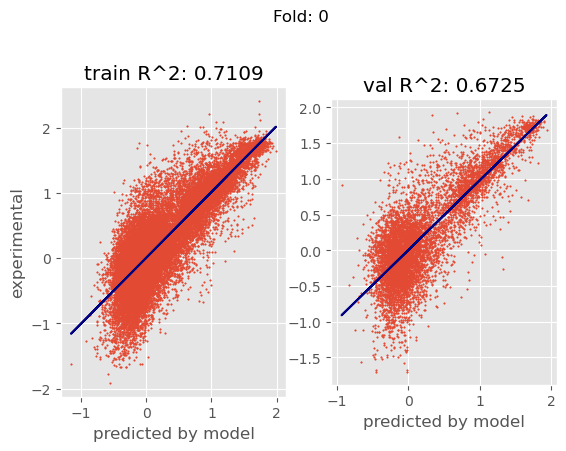

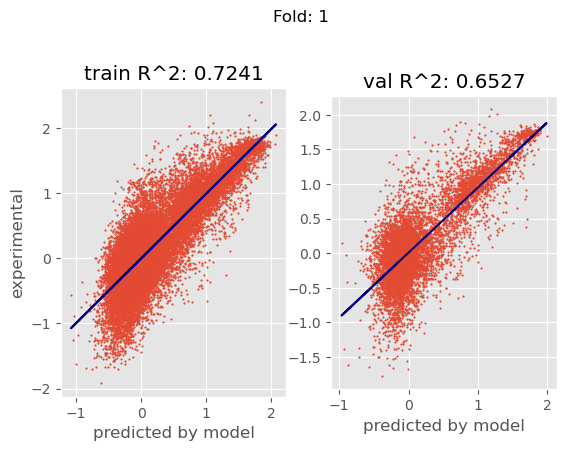

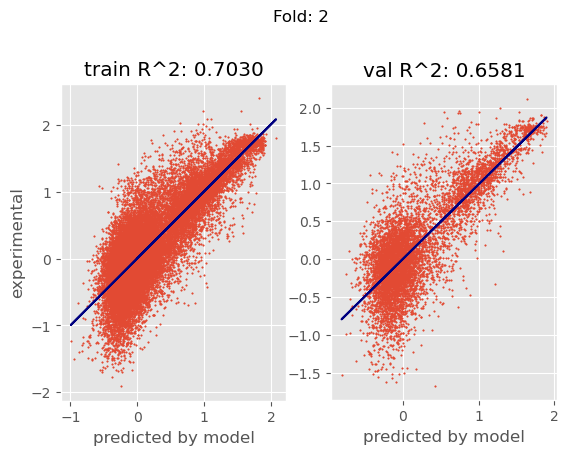

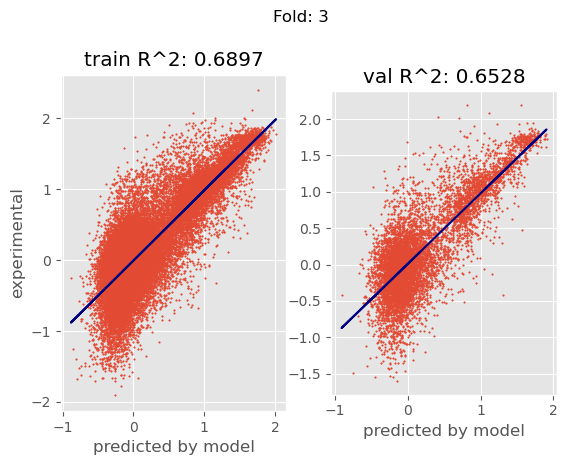

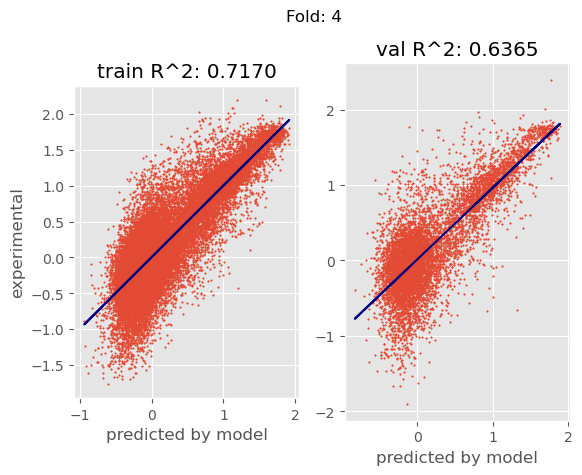

Train (using mean prediction) R^2= 0.7176185641636548
Test (using mean prediction) R^2= 0.27905082143827187


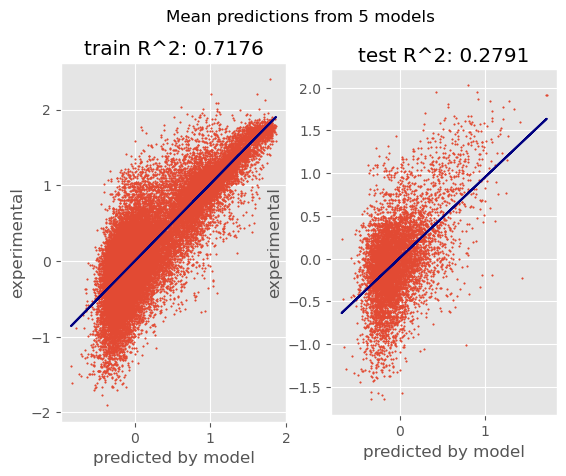

In [99]:
fold_predictions_train = []
fold_predictions_test = []
for fold in sorted(split_data):
    train_index, test_index = split_data[fold]
    x_train = x_full_train.loc[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train.loc[test_index]
    y_val = y_full_train[test_index]

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model = CatBoostRegressor()
    model.load_model(path)

    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)
    pred_full_train = model.predict(x_full_train)
    pred_full_test = model.predict(x_full_test)
    fold_predictions_train.append(pred_full_train)
    fold_predictions_test.append(pred_full_test)

    fig, (ax0, ax1) = plt.subplots(ncols=2)
    ax0.scatter(pred_train, y_train, s=1)
    
    score = r2_score(y_train, pred_train)
    m, b = np.polyfit(pred_train, y_train, 1)
    
    ax0.plot(pred_train, m*pred_train + b, color="navy")
    ax0.set_aspect("equal")
    ax0.set_title(f"train R^2: {score:.4f}")
    ax0.set_xlabel("predicted by model")
    ax0.set_ylabel("experimental")

    ax1.scatter(pred_val, y_val, s=1)
    m, b = np.polyfit(pred_val, y_val, 1)
    ax1.plot(pred_val, m*pred_val + b, color="navy")
    
    ax1.set_aspect("equal")
    score = r2_score(y_val, pred_val)
    ax1.set_title(f"val R^2: {score:.4f}");
    ax1.set_xlabel("predicted by model")
    plt.suptitle(f"Fold: {fold}")
    plt.show()
    plt.close(fig)

train_predictions_mean = np.stack(fold_predictions_train).mean(0)
test_predictions_mean = np.stack(fold_predictions_test).mean(0)
train_predictions_median = np.median(np.stack(fold_predictions_train), 0)
test_predictions_median = np.median(np.stack(fold_predictions_test), 0)

print("Train (using mean prediction) R^2=", r2_score(y_full_train, train_predictions_mean))
# print("Train (using median prediction) R^2=", r2_score(y_full_train, train_predictions_median))

print("Test (using mean prediction) R^2=", r2_score(y_full_test, test_predictions_mean))
# print("Test (using median prediction) R^2=", r2_score(y_full_test, test_predictions_median))

# the same plots for mean predictions - on train and test datasets:
fig, (ax0, ax1) = plt.subplots(ncols=2)
## train
ax0.scatter(train_predictions_mean, y_full_train, s=1)

score = r2_score(y_full_train, train_predictions_mean)
m, b = np.polyfit(train_predictions_mean, y_full_train, 1)

ax0.plot(train_predictions_mean, m*train_predictions_mean + b, color="navy")
ax0.set_aspect("equal")
ax0.set_title(f"train R^2: {score:.4f}")
ax0.set_xlabel("predicted by model")
ax0.set_ylabel("experimental")

## test
ax1.scatter(test_predictions_mean, y_full_test, s=1)

score = r2_score(y_full_test, test_predictions_mean)
m, b = np.polyfit(test_predictions_mean, y_full_test, 1)

ax1.plot(test_predictions_mean, m*test_predictions_mean + b, color="navy")
ax1.set_aspect("equal")
ax1.set_title(f"test R^2: {score:.4f}")
ax1.set_xlabel("predicted by model")
ax1.set_ylabel("experimental");
plt.suptitle(f"Mean predictions from {NFOLDS} models");

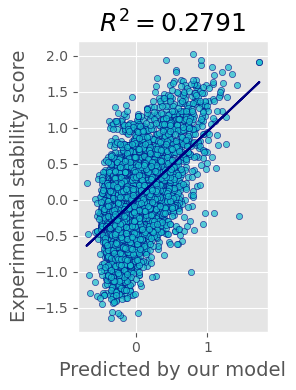

In [100]:
# Draw with different representation 
from sklearn import linear_model
ols = linear_model.LinearRegression()
model = ols.fit(test_predictions_mean.reshape(-1, 1), y_full_test.reshape(-1, 1))
response = model.predict(test_predictions_mean.reshape(-1, 1))

r2 = r2_score(y_full_test, test_predictions_mean)

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(test_predictions_mean, response, color='navy', label='Regression model')
ax.scatter(test_predictions_mean, y_full_test, edgecolor='navy',
           facecolor='tab:cyan', s= 20,
           alpha=0.7, label='Sample data')
ax.set_ylabel('Experimental stability score', fontsize=14)
ax.set_xlabel('Predicted by our model', fontsize=14)

#ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.4f$' % r2, fontsize=18)
ax.set_aspect("equal")
fig.tight_layout()

In [84]:
from scipy.stats import pearsonr

In [101]:
pearsonr(y_full_test, test_predictions_mean)

(0.5293037703180328, 0.0)